# GAN Trained on MNIST

## Imports

In [ ]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt

#### Import utility functions

In [ ]:
from helper_data import get_dataloaders_mnist
from helper_train import train_gan_v1
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_multiple_training_losses
from helper_plotting import plot_generated_images

In [ ]:
##########################
### SETTINGS
##########################

# Device
#CUDA_DEVICE_NUM = 3
#DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 42
GENERATOR_LEARNING_RATE = 0.0002
DISCRIMINATOR_LEARNING_RATE = 0.0002

NUM_EPOCHS = 100
BATCH_SIZE = 128

IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 28, 28, 1

Device: cpu


In [ ]:
set_deterministic
set_all_seeds(RANDOM_SEED)

## Dataset

In [ ]:
##########################
### Dataset
##########################

from torchvision import datasets
from torch.utils.data import DataLoader


custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])


train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=custom_transforms,
                               download=True)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=0,
                          shuffle=True)

# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


In [ ]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


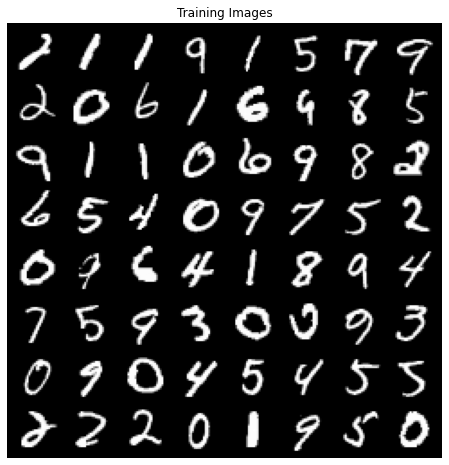

In [ ]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64],
                                         padding=2, normalize=True),
                        (1, 2, 0)))
plt.show()

## Model

In [ ]:
##########################
### MODEL
##########################

class GAN(torch.nn.Module):

    def __init__(self, latent_dim=100,
                 image_height=28, image_width=28, color_channels=1):
        super().__init__()

        self.image_height = image_height
        self.image_width = image_width
        self.color_channels = color_channels

        self.generator = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, image_height*image_width*color_channels),
            nn.Tanh()
        )

        self.discriminator = nn.Sequential(
            nn.Flatten(),
            nn.Linear(image_height*image_width*color_channels, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, 1), # outputs logits
            #nn.Sigmoid()
        )

    def generator_forward(self, z):# z has dimension NCHW
        z = torch.flatten(z, start_dim=1)
        img = self.generator(z)
        img = img.view(z.size(0),
                       self.color_channels,
                       self.image_height,
                       self.image_width)
        return img

    def discriminator_forward(self, img):
        logits = model.discriminator(img)
        return logits

In [ ]:
set_all_seeds(RANDOM_SEED)

model = GAN()
model.to(DEVICE)


optim_gen = torch.optim.Adam(model.generator.parameters(),
                             betas=(0.5, 0.999),
                             lr=GENERATOR_LEARNING_RATE)

optim_discr = torch.optim.Adam(model.discriminator.parameters(),
                               betas=(0.5, 0.999),
                               lr=DISCRIMINATOR_LEARNING_RATE)

## Training

In [ ]:
log_dict = train_gan_v1(num_epochs=NUM_EPOCHS, model=model,
                        optimizer_gen=optim_gen,
                        optimizer_discr=optim_discr,
                        latent_dim=100,
                        device=DEVICE,
                        train_loader=train_loader,
                        logging_interval=100,
                        save_model='gan_mnist_01.pt')

Epoch: 001/100 | Batch 000/469 | Gen/Dis Loss: 0.7355/0.6879
Epoch: 001/100 | Batch 100/469 | Gen/Dis Loss: 0.6067/0.4896
Epoch: 001/100 | Batch 200/469 | Gen/Dis Loss: 0.6378/0.5583
Epoch: 001/100 | Batch 300/469 | Gen/Dis Loss: 0.7000/0.5596
Epoch: 001/100 | Batch 400/469 | Gen/Dis Loss: 0.8475/0.4672
Time elapsed: 0.23 min
Epoch: 002/100 | Batch 000/469 | Gen/Dis Loss: 1.1436/0.3605
Epoch: 002/100 | Batch 100/469 | Gen/Dis Loss: 1.1206/0.3907
Epoch: 002/100 | Batch 200/469 | Gen/Dis Loss: 0.9675/0.4388
Epoch: 002/100 | Batch 300/469 | Gen/Dis Loss: 1.0509/0.4042
Epoch: 002/100 | Batch 400/469 | Gen/Dis Loss: 1.0536/0.4318
Time elapsed: 0.47 min
Epoch: 003/100 | Batch 000/469 | Gen/Dis Loss: 1.1733/0.4338
Epoch: 003/100 | Batch 100/469 | Gen/Dis Loss: 1.2683/0.4645
Epoch: 003/100 | Batch 200/469 | Gen/Dis Loss: 1.0995/0.4255
Epoch: 003/100 | Batch 300/469 | Gen/Dis Loss: 1.2307/0.4437
Epoch: 003/100 | Batch 400/469 | Gen/Dis Loss: 1.1075/0.4798
Time elapsed: 0.70 min
Epoch: 004/100 |

## Evaluation

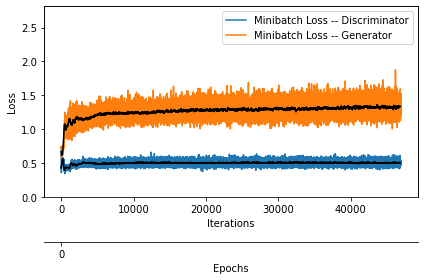

In [ ]:
plot_multiple_training_losses(
    losses_list=(log_dict['train_discriminator_loss_per_batch'],
                 log_dict['train_generator_loss_per_batch']),
    num_epochs=NUM_EPOCHS,
    custom_labels_list=(' -- Discriminator', ' -- Generator')
)

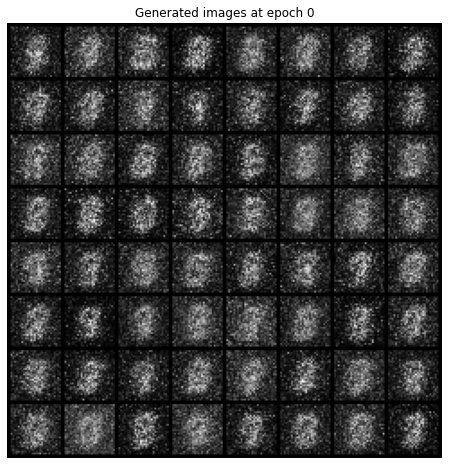

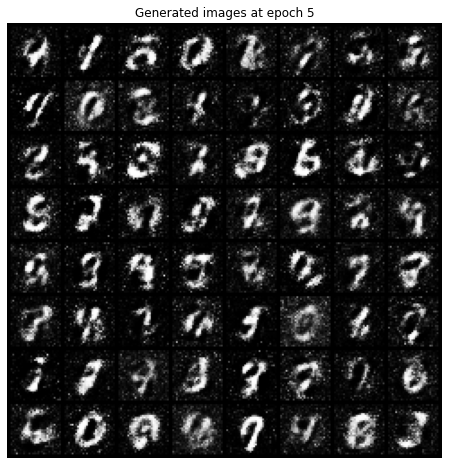

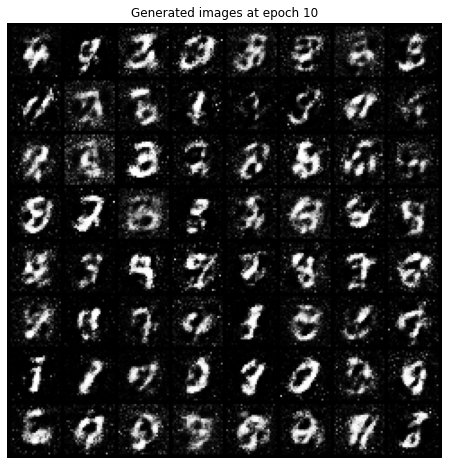

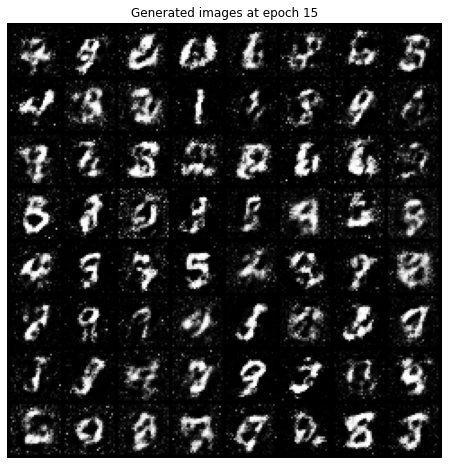

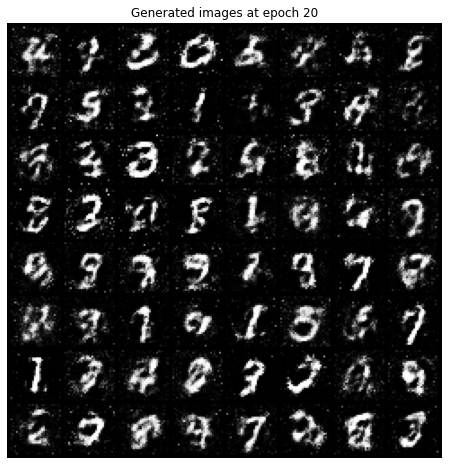

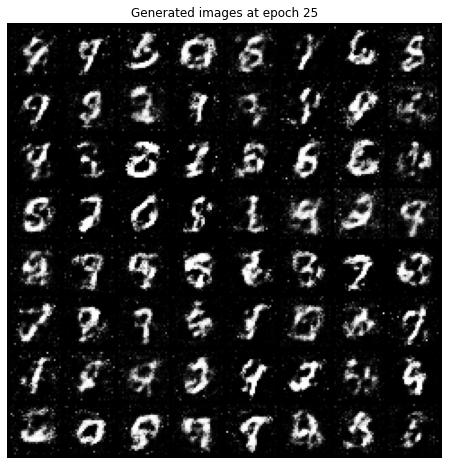

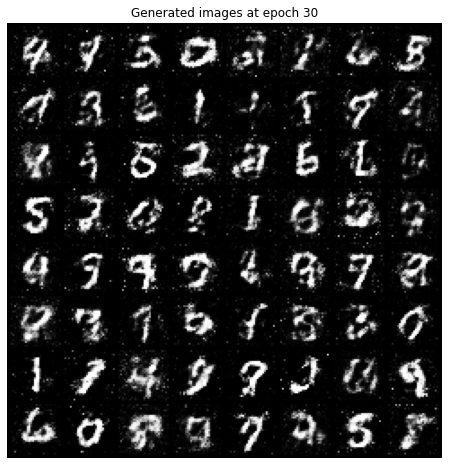

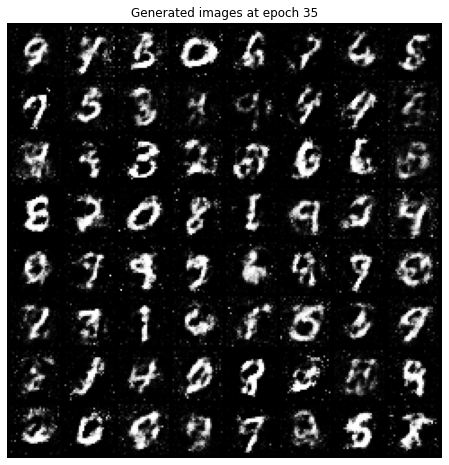

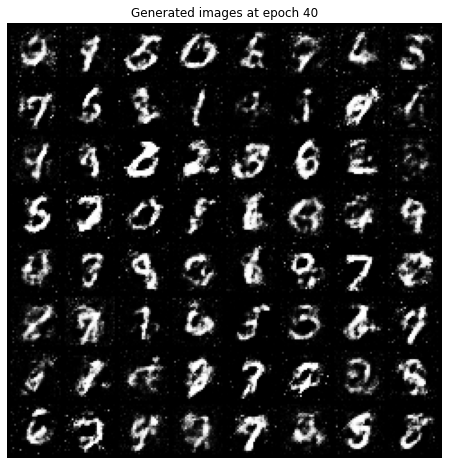

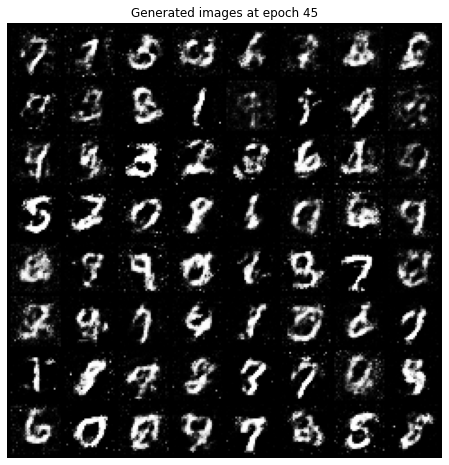

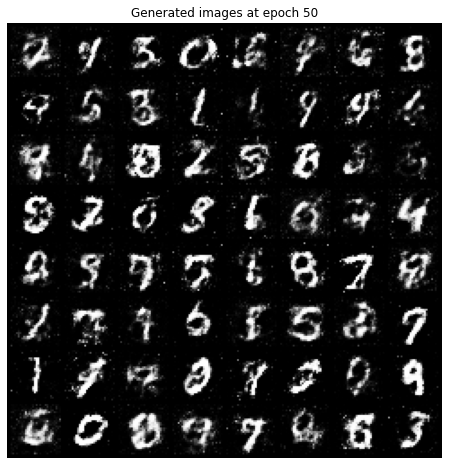

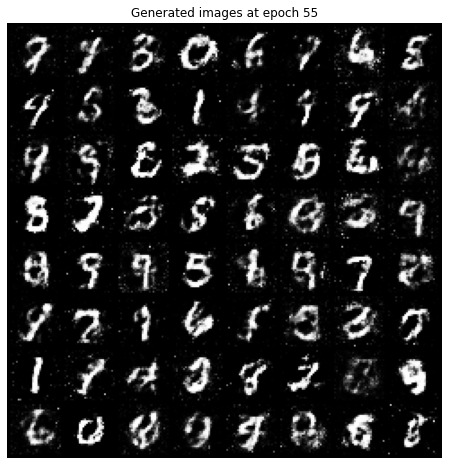

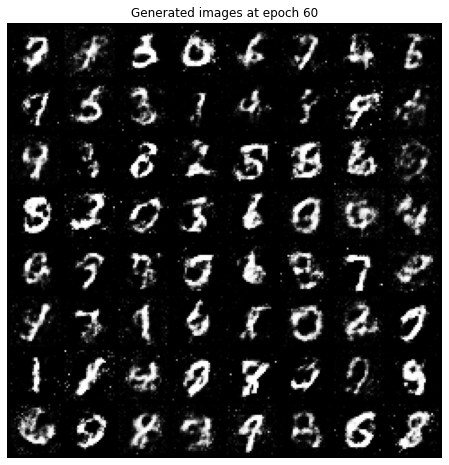

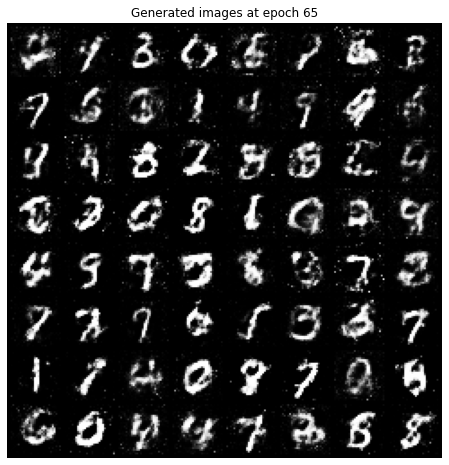

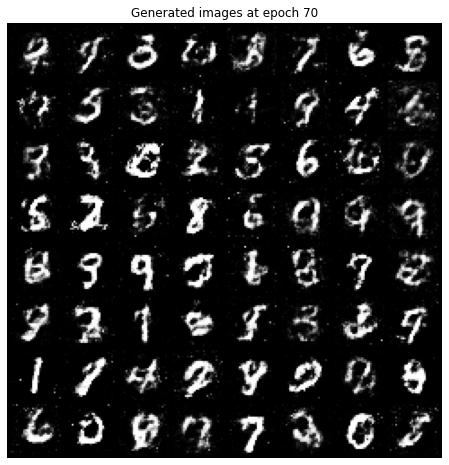

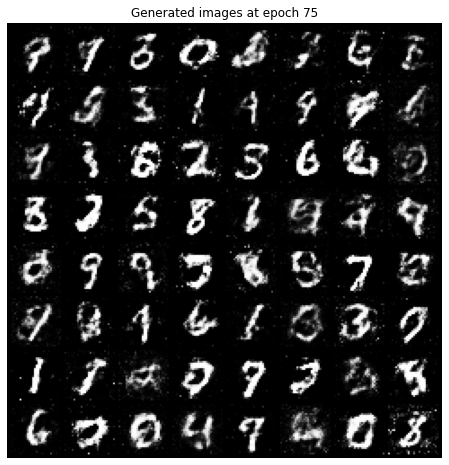

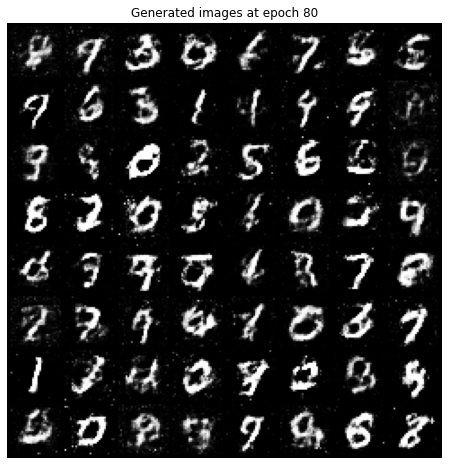

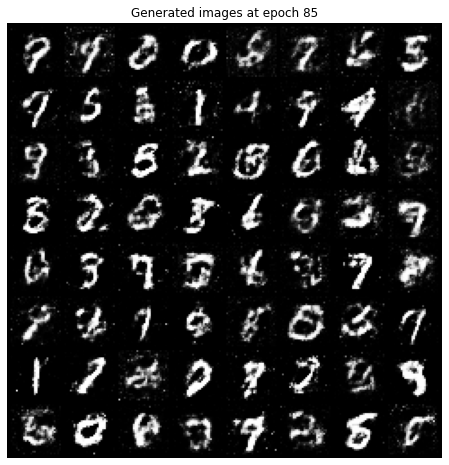

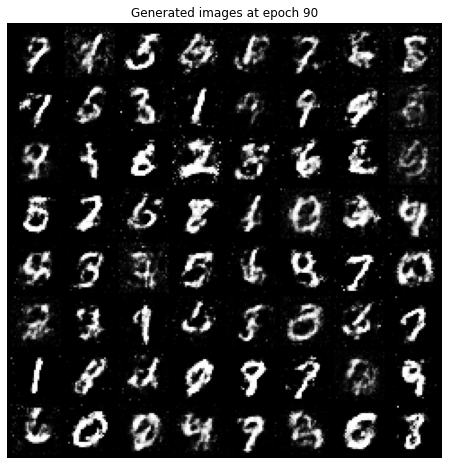

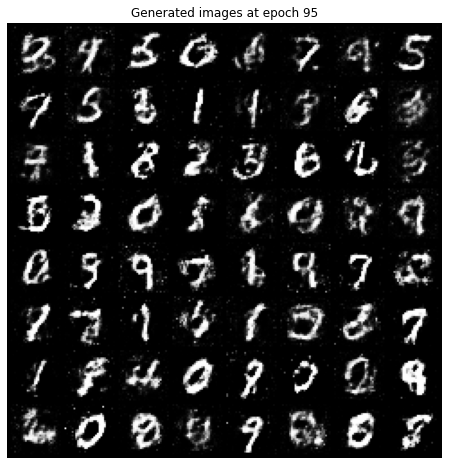

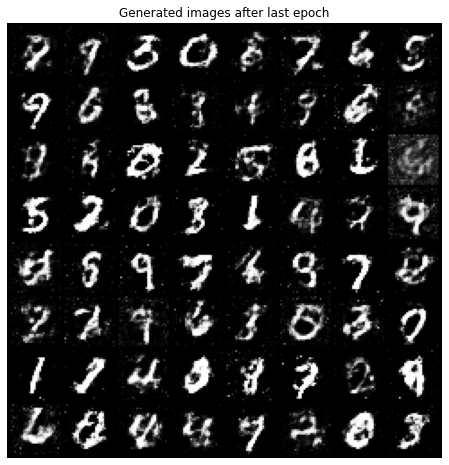

In [ ]:
##########################
### VISUALIZATION
##########################

for i in range(0, NUM_EPOCHS, 5):

    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.title(f'Generated images at epoch {i}')
    plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][i], (1, 2, 0)))
    plt.show()


plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title(f'Generated images after last epoch')
plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][-1], (1, 2, 0)))
plt.show()